# Attentions


<table>
<tr>
  <th colspan=2>The base attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention.png"/>
  </td>
</tr>
</table>

In [3]:
# Write attention code
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        assert d_model % self.num_heads ==0
        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x ,batch_size):
        x= tf.reshape(x, (batch_size, -1 , self.num_heads, self.depth))
        return tf.transpose(x,perm=[0,2,1,3])

    def call(self, q, k ,v ,mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention , attention_weights = self.scaled_dot_product_attention(q,k,v,mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0,2,1,3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, d_model))

        output = self.dense(concat_attention)

        return output, attention_weights

    def scaled_dot_product_attention(self, q, k, v ,mask):
        matmul_qk = tf.matmul(q,k,transpose_b=True)
        d_k = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(d_k)

        if mask is not None:
            scaled_attention_logits += (mask*-1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis = -1 )
        output = tf.matmul(attention_weights, v)
        return output, attention_weights


Output shape: (2, 10, 4)
Attention weights shape: (2, 4, 10, 10)


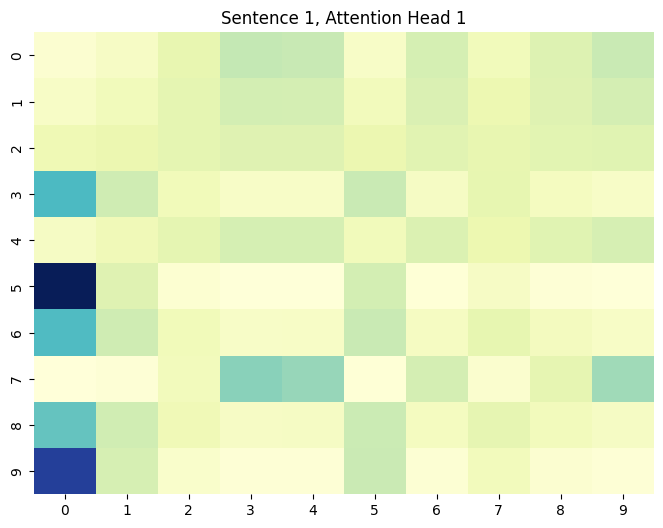

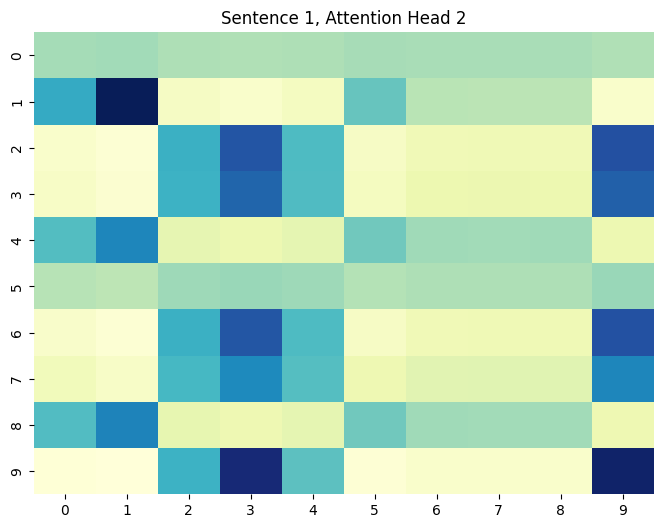

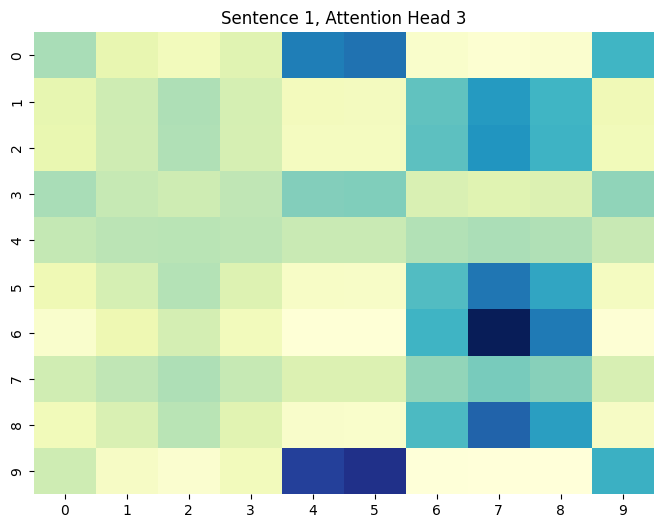

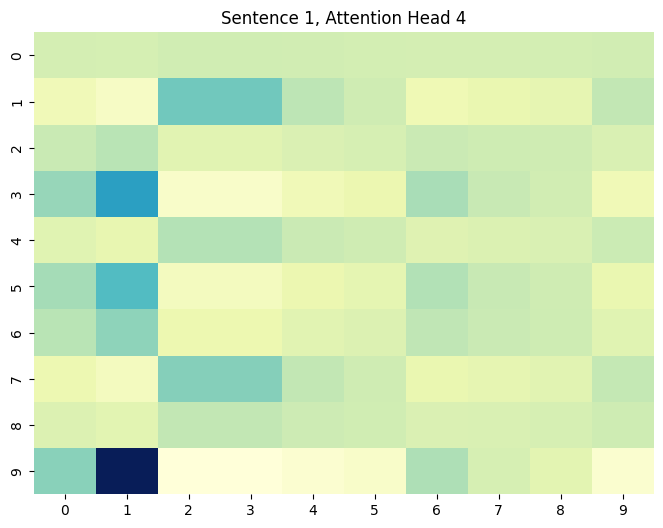

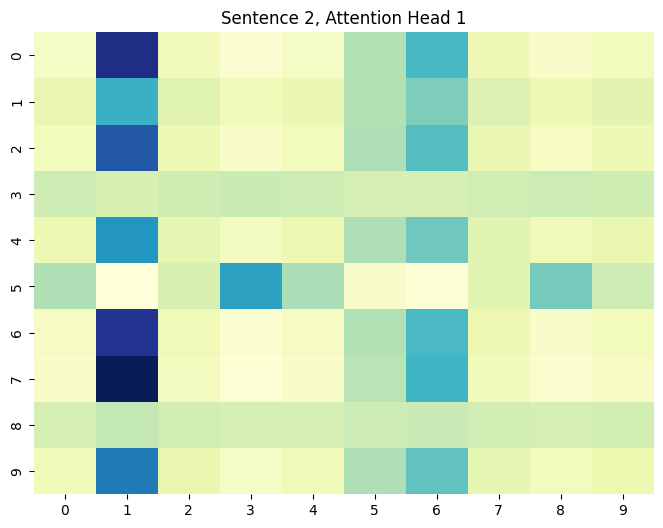

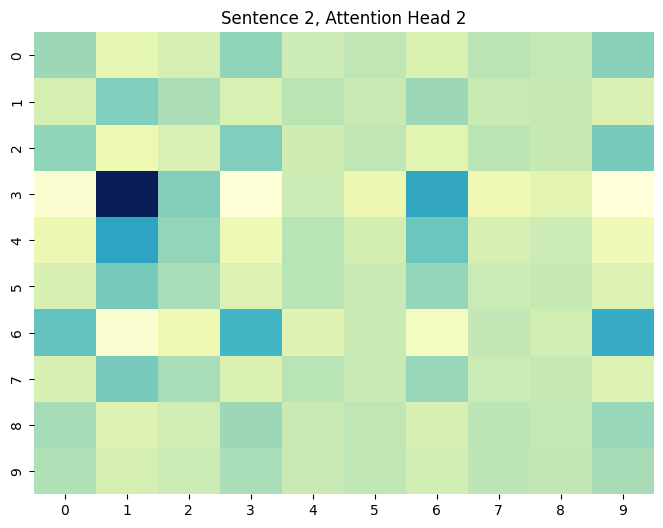

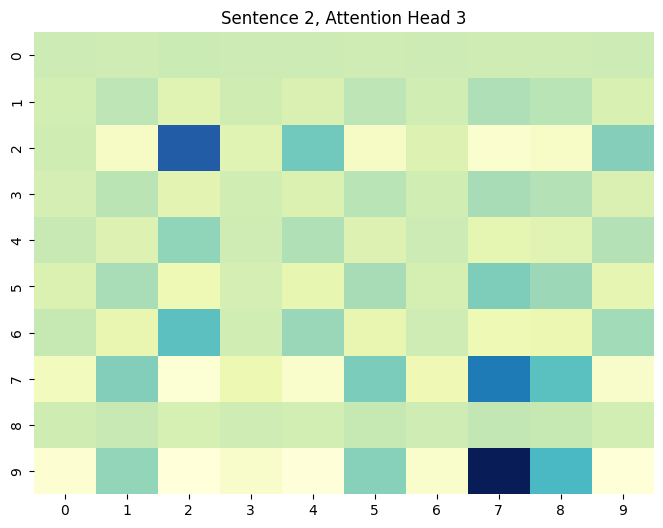

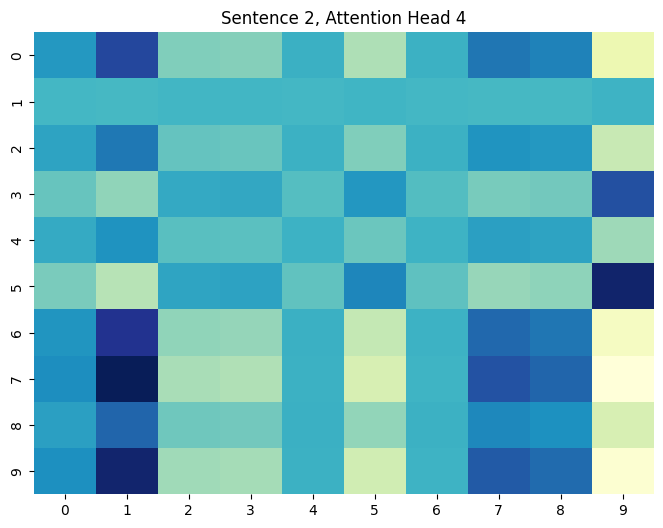

In [4]:
# Create input tensors for two sentences (batch_size = 2)
batch_size = 2
sequence_length = 10
d_model = 4  # Set the dimensionality of the model's input to 8

# Randomly initialize query, key, and value tensors for two sentences
q = tf.random.normal((batch_size, sequence_length, d_model))
k = tf.random.normal((batch_size, sequence_length, d_model))
v = tf.random.normal((batch_size, sequence_length, d_model))

mask = None  # For this example, we won't use a mask

# Initialize the MultiHeadAttention layer and call it
num_heads = 4  # Define the number of heads
mha = MultiHeadAttention(d_model, num_heads)
output, attention_weights = mha(q, k, v, mask)

# Display the shapes of the output and attention weights
print("Output shape:", output.shape)
print("Attention weights shape:", attention_weights.shape)

# Visualize attention weights for each head
for i in range(batch_size):
    for head in range(num_heads):
        plt.figure(figsize=(8, 6))
        sns.heatmap(attention_weights[i, head], cmap="YlGnBu", cbar=False)
        ax = plt.gca()
        ax.set_title(f'Sentence {i+1}, Attention Head {head+1}')
        plt.show()


### **Reference Links**

#### Positional Encoding
https://www.youtube.com/watch?v=dichIcUZfOw

https://kazemnejad.com/blog/transformer_architecture_positional_encoding/

https://pylessons.com/transformers-introduction

In [5]:
!pip install transformers
!pip install sentencepiece


In [6]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Load the pre-trained English to Urdu translation model and tokenizer
model_name = "Helsinki-NLP/opus-mt-en-ur"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Input English text to be translated to Urdu
input_text = "Hello, how are you?"

# Tokenize the input text
input_ids = tokenizer.encode(input_text, return_tensors="pt")

# Generate translation
translation_ids = model.generate(input_ids, max_length=100, num_return_sequences=1, no_repeat_ngram_size=2, top_k=50, top_p=0.95, early_stopping=True)

# Decode the generated translation
translation = tokenizer.decode(translation_ids[0], skip_special_tokens=True)

print("English Input:", input_text)
print("Urdu Translation:", translation)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/816k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/848k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/306M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


English Input: Hello, how are you?
Urdu Translation: ہیلو، تم کیسے ہو؟
